In [81]:
# !conda install ffmpeg -y
# !conda install -c conda-forge librosa -y

### Time and Frequency Representation of Signals

#### Setting up our libraries

In [82]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io.wavfile import write
from scipy.fft import irfft, rfft
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
import IPython
from IPython.display import Audio
from pydub import AudioSegment
import soundfile as sf
from scipy.signal import blackman

#### Time domain representation
The first kind of visualization of signals is called the **time-domain** representation of a given signal. In the field of
audio signals this representation reflects the changes in the amplitude of the signal as **time** progresses.

The simplest audio wave is a periodic **sine** wave: $s(t)=sin(2\pi f t)$
The following code generates simple periodic waves:

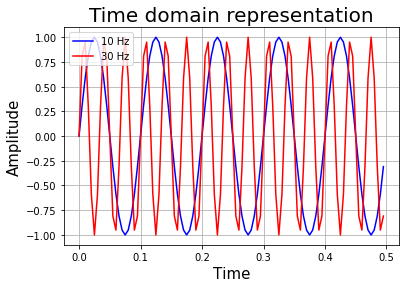

In [70]:
samples_per_second = 200  # Hz
duration = 0.5  # Sec

def generate_periodic_signal(freq, sample_rate, duration):
    N = int(sample_rate*duration)
    T=1/sample_rate
    x = np.linspace(0.0, N*T, N, endpoint=False)
    frequencies = x * freq
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Generate two periodic sine waves that last for 1 second
f1 = 10 #Hz
f2 = 30 #Hz
x1, y1 = generate_periodic_signal(f1, samples_per_second, duration)
x2, y2 = generate_periodic_signal(f2, samples_per_second, duration)
plt.plot(x1, y1, "-b", label = str(f1)+" Hz")
plt.plot(x2, y2, "-r", label = str(f2)+" Hz")
plt.legend(loc="upper left")
plt.xlabel('Τime', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.title('Time domain representation', fontsize=20)
plt.grid()
plt.show()

#### Frequency Domain representation
The **time domain** representation of the signal is easily understandable, however it is **not** always informative. Transforming
a function of **time** to the **frequency** domain means we decompose the signal to its frequency components similar to the
way that a prism decomposes light to its color components. **Fourier Transform** is a mathematical concept that can convert
a continuous signal from the time-domain to the frequency-domain, allowing us to get a better view of the frequencies present in the
signal.

As we are working with digital data, we are going to use the Discrete Fourier Transform (**DFT**):

$X[k] = \sum_{n=1}^{N-1} e^{-2\pi*\frac{jkn}{N}}*x[n]$, (**DFT**)

where **x[n]** is the digital time domain representation of the signal and N is the length of **x[n]**.
The inverse DFT takes as input the X[k] components and returns the initial signal:

$x[n] = \frac{1}{N} \sum_{n=1}^{N-1} e^{2\pi*\frac{jkn}{N}}*X[k]$, (**IDFT**)

Thus, the initial signal, x(n), can be written as a **weighed sum** of the basis functions.

* The basis functions are the **complex exponentials** $e^{2\pi*\frac{jkn}{N}}$
* The weight on the **kth** complex exponential is equal to the **X[k]**

The $k^{th}$ frequency sample corresponds to the analog frequency $f_k=\frac{kF_s}{N},k=0,…,N-1$.
where $F_s$ is the sampling rate that was used to sample $x(n)$,
For a given sampling rate, longer observation period N results in better frequency resolution,
as $\frac{Fs}{N}$ becomes smaller.

Python **scipy.fft** calculates
the **DFT** of a signal, using the Fast Fourier Transform Algorithm (**FFT**). The following function is used
to plot the positive frequency terms of the FFT.

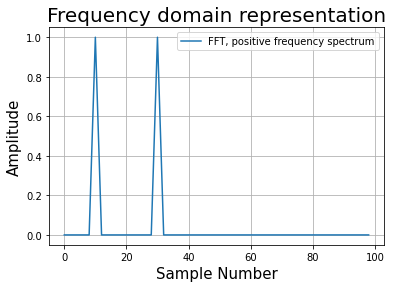

In [76]:
def plot_fft(number_of_samples, samples_per_second, y):
    yf = rfft(y)
    T = 1/samples_per_second
    xf = fftfreq(number_of_samples, T)[0:number_of_samples//2]
    plt.plot(xf, 2.0/number_of_samples * np.abs(yf[0:number_of_samples//2]), label ='FFT, positive frequency spectrum')
    plt.legend(loc="upper right")
    plt.xlabel('Frequency', fontsize=15)
    plt.ylabel('Amplitude', fontsize=15)
    plt.title('Frequency domain representation', fontsize=20)
    plt.grid()
    plt.show()
    return xf,yf

N = int(samples_per_second * duration)
y = y1+y2
xf,yf = plot_fft(N, samples_per_second, y)

Every **finite** discrete signal can be modeled as multiplication of an **infinite** signal with a rectangular window
function. In the frequency domain, **multiplication** becomes **convolution** of the signal
spectrum with the window function spectrum. This operation causes an effect called **spectral leakage**. To compensate
with this effect, we multiply the signal with a **dedicated** window function.

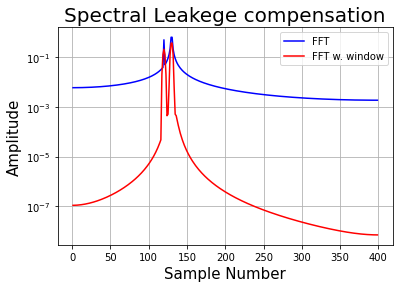

In [80]:
def plot_wfft(samples_per_second,duration, f1,f2):
    x1, y1 = generate_periodic_signal(f1, samples_per_second, duration)
    x2, y2 = generate_periodic_signal(f2, samples_per_second, duration)
    N = int(duration*samples_per_second)
    y = y1+0.5*y2
    yf = fft(y)
    w = blackman(N)
    ywf = fft(y*w)
    xf = fftfreq(N, 1/samples_per_second)[:N//2]
    plt.xlabel('Frequency', fontsize=15)
    plt.ylabel('Amplitude', fontsize=15)
    plt.title('Spectral Leakage compensation', fontsize=20)
    plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
    plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')
    plt.legend(['FFT', 'FFT w. window'])
    plt.grid()
    plt.show()

samples_per_second = 800 # Hz
duration = 0.75  # Sec
f1 = 130 #Hz
f2 = 120 #Hz
N = int(samples_per_second * duration)
plot_wfft(samples_per_second, duration, f1, f2)

It becomes clear that the **FFT** algorithm can **distinguish** the frequency components of the mixed signal.
Each **frequency** component is presented on the plot in the **sample number** it corresponds to. Knowing
the total number of samples, and the samples per second, we can also find the **natural frequency** components.
**FFT** decomposes the signal to **complex sinusoids** and finds each sinusoid's contribution
to the signal. This explains why we can see only **two tones** centred in the frequency of each sinusoid.

Now we will use these tools to better understand the significance of
the Fourier transform. The first step is to record your voice and plot the
time domain and frequency domain representation of the recorded signal.

In [5]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [84]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")
print(sig.shape)
Audio(data=sig, rate=sr)
filename = 'file.wav'
data, fs = sf.read(filename, dtype='float32')
plt.plot(data)
plt.title('Audio signal (time-domain', fontsize=20)
plt.xlabel('Sample Number', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.grid()
plt.show()

The Next step is to add a noise signal to the initial audio signal to corrupt it.

In [83]:
fn = 100000
nf, ny = generate_periodic_signal(fn, fs, len(data)//fs)
corrupted_signal = (ny/10) + data[len(data)%fs:]
x_corrupted, y_corrupted = plot_fft(fs*(len(data)//fs), fs, corrupted_signal)
normalized_corrupted = np.int16((corrupted_signal / corrupted_signal.max()) * 32767)
normalized_initial = (data[len(data)%fs:] / corrupted_signal.max()* 32767)
plt.plot(normalized_corrupted, label ='Corrupted signal')
plt.plot(normalized_initial, label ='Initial Signal')
plt.legend(loc="upper right")
plt.title('Noise Corruption', fontsize=20)
plt.xlabel('Sample Number', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.grid()
plt.show()
write("corrupted.wav", fs, normalized_corrupted)
IPython.display.Audio("corrupted.wav")